# Bootstrapping with Python

This notebook introduces you to the bootstrapping method, which can be used to estimate statistics such as the expected value or the confidence intervals. In the bootstrapping method, the observed data is used to create a sample from which the desired statistic is calculated. Then, this process is repeated in order to determine the quantity of interest from the replications.   

We'll start by reviewing Monte Carlo simulation because it is closely related to the bootstrapping method. The main difference is that in the Monte Carlo method, the simulated samples are drawn from a known distribution. Otherwise, the methods follow the same steps. 

After discussing the Monte Carlo method, we'll explore two different bootstrapping techniques: _the iid bootstrap_ and _the circular block bootstrap_, showing an example of each in Python. We use the bootstrapping techniques to estimate the confidence interval of the performance metric AUC (Area Under the Curve). 

## Monte Carlo simulation method

The Monte Carlo simulation method follows the steps:
1. Generate a sample from a known distribution.
2. Calculate the statistic of interest.
3. Repeat steps 1 and 2 to create the distribution of the statistic.
4. Estimate the quatity of interest from the distribution.

More formally, let's say we assume that a random variable $X$ comes from a normal distribution, or $X \sim \mathcal{N}(\mu,\,\sigma^{2})$. Thus, we simulate a sample of $X$ with $N$ values that are normaly distributed: $x_1, x_2,..., x_n$. 

Then, we calculate the value of the function $g(X)$ using the sample.

We repeat the process of generating samples and calculating function values $n$ times. Thus, we get $g_1, g_2,..., g_n$.

Finally, we estimate the quantity of interest. For example, the expected value of the function $\frac{1}{n} \Sigma \, g(X)$.

### Why simulate? And what can go wrong?

Simulations are great for solving problems where the distribution of the desired statistic is unknown or where the system is too complex for analytical solutions. However, if the data generation process does not adequately describe the problem at hand, then the results of the simulation may be unreliable. Specifying the data generation process is typically one of the biggest challenges when using simulations.

An important factor to consider is the computational cost. Running many complex simulations can be very time-consuming and may limit an analyst's ability to assess the assumed specification. Therefore, simulations should be preferred only when analytical expressions are not available.

## Bootstrapping

In contrast to the Monte Carlo approach, the bootstrapping method uses directly the observed data to create simulated samples. It does not make assumptions about the distribution, thus the only thing that is being simulated is the choice of observations to construct samples.   

### iid bootstrap

In the idd bootstrap, samples are created by drawing with replacement (i.e. an observation can occur multiple times in a sample) from the observed data. 

For example, if we have observed data $x_1, x_2,..., x_{20}$ and we want to create 5 samples with 4 observations each, the samples can look like the following:

| Sample 1 | Sample 2 | Sample 3 | Sample 4 | Sample 5 |
| -------- | -------- | -------- | -------- | -------- |
| $x_1$    | $x_2$    | $x_2$    | $x_1$    | $x_4$    |
| $x_3$    | $x_6$    | $x_9$    | $x_5$    | $x_{10}$ |
| $x_{12}$ | $x_{17}$ | $x_{17}$ | $x_7$    | $x_{11}$ |
| $x_3$    | $x_{19}$ | $x_{18}$ | $x_{13}$ | $x_{20}$ |

In the example, the observation $x_3$ is repeated twice in the sample 1 and the samples 2 and 3 overlap. This can be expected when samples are created with replacement. 

### circular block bootstrap

The idd method is an appropriate choice, when observations are independent. If there's dependence, for example across time, more sophisticated methods are needed.

The circular block bootstrap (CBB) samples blocks with replacement, instead of sampling a single observation, so that the blocks contain consecutive observations. For example, if we have observed data $x_1, x_2,..., x_{10}$, the size of a block is 6, and the number of blocks is also 6, the samples look the following:

| Sample 1 | Sample 2 | Sample 3 | Sample 4 | Sample 5 | Sample 6 |
| -------- | -------- | -------- | -------- | -------- | -------- |
| $x_1$    | $x_2$    | $x_3$    | $x_4$    | $x_5$    | $x_6$    |
| $x_2$    | $x_3$    | $x_4$    | $x_5$    | $x_6$    | $x_7$    |
| $x_3$    | $x_4$    | $x_5$    | $x_6$    | $x_7$    | $x_8$    |
| $x_4$    | $x_5$    | $x_6$    | $x_7$    | $x_8$    | $x_9$    |
| $x_5$    | $x_6$    | $x_7$    | $x_8$    | $x_9$    | $x_{10}$ |
| $x_6$    | $x_7$    | $x_8$    | $x_9$    | $x_{10}$ | $x_1$    |

The final block wraps around as if the 1st observation occurs after the 10th observation.

The block size should be large enough to capture the dependence, but on the other hand it cannot be too large in order that the number of blocks is sufficient. The recommended size of a block is $\sqrt{n}$, where $n$ is the size of the observed data.

### Python example

In this Python example, we calculate the confidence interval for the AUC metric that is often used as a peformance metric for statistical models predicting default risk. We use both the iid method and the CBB method to calculate the confidence interval.

The data at hand is a training sample from a modeling project, containing default risk predictions for consumers (see _id_ in the data) and information on whether or not a consumer defaulted within 12 months from the prediction.  

#### Load packages and data

We load the packages needed for data handling and simulation, and then we import the data and make the necessary corrections to the data types of the columns.


In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.metrics import roc_auc_score
import seaborn as sns
import itertools

# Set seed
np.random.seed(123)

# Import data
dt = pd.read_csv('predictions.csv',sep=';')

# Check data types 
# df.info()

# Correct columns
dt['pred_value'] = dt['pred_value'].str.replace(',','.')
dt['pred_value'] = pd.to_numeric(dt['pred_value'])

# Suffle data
random_order = np.random.choice(range(0,len(dt)),size=len(dt),replace=False)
df = dt.iloc[random_order]


#### Data exploration

We have 125 839 consumers with the average default rate of 0.9568 %.

In [39]:
df.vaste_12kk.describe()

count    125839.000000
mean          0.009568
std           0.097346
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: vaste_12kk, dtype: float64

#### Confidence interval with the iid method 

We use the iid method to construct samples from the observed data. Before drawing samples, we set the seed to ensure the results can be replicated afterwards. Then, the sample size and the number of samples are determined. Finally, a for loop is used to generate the samples and calculate the AUC metric for each iteration.

In [53]:
# Save the resulting metrics to a vector
res_auc = []

# Determine the sample size and the number of samples
sample_size = 20000
sample_N = 1000

# For loop to simulate

for i in range(sample_N):
    
    # Generate random numbers that indicate the row numbers of the observed data. Then 
    # a bootstrap sample is created by filtering the observed data using the random row numbers.

    selected_rows = np.random.choice(range(0,len(df)),size=sample_size,replace=True)

    bootstrap_sample = df.iloc[selected_rows]

    # Calculate AUC from the bootstrap sample
    res = roc_auc_score(bootstrap_sample.vaste_12kk, bootstrap_sample.pred_value)

    res_auc.append(res)

Next we estimate the confidence interval for the AUC metric from the bootstrap distribution. The plot below shows the bootstrap distribution is symmetric, indicating that estimating the confidence interval using percentiles of the bootstrap distribution is appropriate. 

Text(0, 0.5, 'Density')

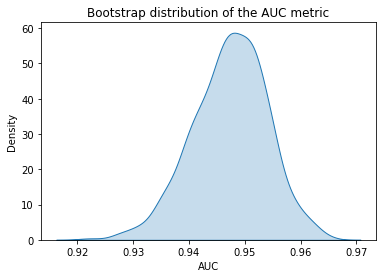

In [54]:
sns.kdeplot(res_auc, shade=True)

plt.title('Bootstrap distribution of the AUC metric')
plt.xlabel('AUC')
plt.ylabel('Density')

In [55]:
# 95 % confidence interval
np.percentile(res_auc, [2.5, 97.5])

array([0.93321873, 0.95971711])

#### Confidence interval with the CBB method 

Now we use the CBB method to construct samples from the observed data.

In [56]:
# Save the resulting metrics to a vector
res_auc = []

# First we used the recommended block size which is the square root of the size of the observed data
# block_size = int(np.round(np.sqrt(len(df)),0))
# However, we got several bootstrap samples that had only 0 values and so calculating the AUC wasn't possible
# Thus, the block size was increased to 1000.  

# Determine the block size and the number of samples
block_size = 1000
sample_N = 15000
observed_data_N = len(df)

# Generate blocks 
cbb_blocks = []

for i in range(1,sample_N):
    
    start_point = i % observed_data_N # Modulo
    end_point = np.absolute(observed_data_N-start_point)
    
    if start_point == 0:
        block = itertools.chain(range(observed_data_N,observed_data_N+1), range(1,block_size))
    elif start_point+block_size < observed_data_N:
        block = itertools.chain(range(start_point,start_point+block_size))
    else:
        # Start recycling values 
        block = itertools.chain(range(start_point,observed_data_N+1), range(1,block_size-end_point))
        
    cbb_blocks.append(list(block))
    
# To be further developed in the code:
# 1) The code does not take into account that the indexing is started at 0 in Python.
# 2) Not possible to set sample_N greater to observed_data_N.
        

In [57]:
# Save results in this
res_auc = []

# For loop to simulate
for i in range(sample_N-1):
    
    bootstrap_sample = df.iloc[cbb_blocks[i]]

    # Calculate AUC from the bootstrap sample
    res = roc_auc_score(bootstrap_sample.vaste_12kk, bootstrap_sample.pred_value)
    res_auc.append(res)

Text(0, 0.5, 'Density')

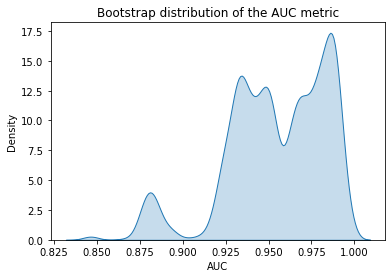

In [58]:
sns.kdeplot(res_auc, shade=True)

plt.title('Bootstrap distribution of the AUC metric')
plt.xlabel('AUC')
plt.ylabel('Density')

In [59]:
# 95 % confidence interval
np.percentile(res_auc, [2.5, 97.5])

array([0.87972594, 0.99203947])

The wavy nature of the curve above shows how the circular block method is not suitable for the problem at hand. Some AUC values are more likely or common than others. This is due to the method the blocks are created. The AUC value does not change much, if at all, when one observation is removed and another is added compared to the last block. Furthermore, if the same blocks appear multiple times, this also makes some AUC values more likely than others. In other words, the circular block methods captures the data structure, which is not desired in AUC calculations. 

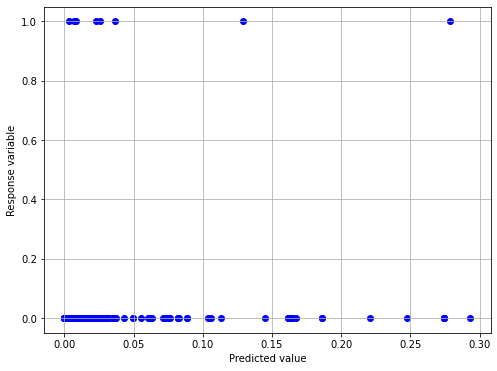

In [60]:
# To examine the response variable in bootstrap samples
x = df.iloc[cbb_blocks[0]].pred_value
y = df.iloc[cbb_blocks[0]].vaste_12kk

plt.figure(figsize=(8, 6))
plt.scatter(x, y, marker='o', color='b')

plt.xlabel('Predicted value')
plt.ylabel('Response variable')
plt.grid(True)

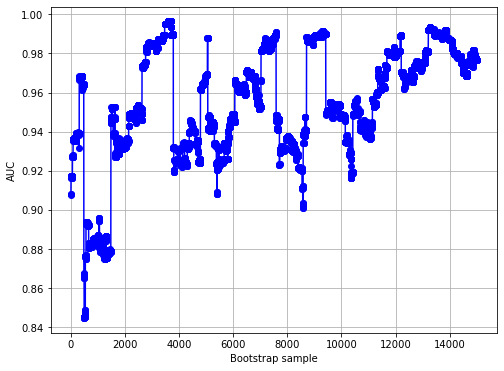

In [61]:
# To examine the AUC values over the bootstrap samples
x = res_auc

plt.figure(figsize=(8, 6))
plt.plot(x, marker='o', color='b')

plt.xlabel('Bootstrap sample')
plt.ylabel('AUC')
plt.grid(True)

### Conclusions

The example shows that the iid method is more suitable for the problem at hand than the circular block method, since there is no dependence between the observations.

## Reference

https://en.wikipedia.org/wiki/Bootstrapping_(statistics)

FRM: Quantitative Analysis by Global Association of Risk Professionals